# Fraud Detection Ledger 프로젝트 개요
본 프로젝트는 ERP 회계전표 데이터를 활용하여 자금 횡령 및 부정거래를 자동으로 탐지하는 시스템입니다.

데이터 불러오기부터 전처리, 비지도학습 및 지도학습을 통한 이상 거래 탐지, 시각화까지 과정을 포함하였습니다.


In [1]:
import pandas as pd
#데이터 불러오기
df = pd.read_csv(r'C:\Users\HyunSu\Desktop\Fraud Detection Ledger\data\fake_journal_entries_500_final.csv')
#데이터 정보 확인
print(df.head())
print(df.info())
print(df.describe())

         date   time  amount entered_by       vendor     description  \
0  2025-04-13  20:07  439262     user05  Hyundai Inc     Outsourcing   
1  2025-12-15  00:47  518268     user05       SK Ltd    Project Cost   
2  2025-09-28  08:15  694148     user01  Hyundai Inc  Travel Expense   
3  2025-04-17  07:08  537828     user04       SK Ltd  Travel Expense   
4  2025-03-13  23:06  -69213     user05       SK Ltd  Travel Expense   

   is_holiday  
0           0  
1           0  
2           0  
3           0  
4           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         500 non-null    object
 1   time         500 non-null    object
 2   amount       500 non-null    int64 
 3   entered_by   500 non-null    object
 4   vendor       500 non-null    object
 5   description  500 non-null    object
 6   is_holiday   500 non-null    int64

In [2]:
#머신러닝 준비과정

# 시간 파생 변수 및 야간 입력 여부
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M')
df['hour'] = df['time'].dt.hour
df['is_late_entry'] = (df['hour'] >= 18).astype(int)
# 공휴일 학습
import holidays
kr_holidays = holidays.KR(years=2025)
kr_holiday_dates = pd.to_datetime(list(kr_holidays.keys()))
df['is_holiday'] = df['date'].isin(kr_holiday_dates).astype(int)

In [4]:
#비지도학습 (isoltation forest)
from sklearn.ensemble import IsolationForest
# 입력 피처 지정 
X_iso = df[['amount', 'hour', 'is_late_entry', 'is_holiday']]
# 모델 정의 및 이상치 탐지
iso_model = IsolationForest(contamination=0.1, random_state=57)
df['anomaly_score'] = iso_model.fit_predict(X_iso)  # -1: 이상, 1: 정상
df['is_anomaly'] = df['anomaly_score'] == -1        # True/False → 이상치 여부
# 결과 출력 
print("Isolation Forest 이상치 탐지 결과:")
print(df['is_anomaly'].value_counts())
print(f"이상치 비율: {df['is_anomaly'].mean() * 100:.2f}%")

Isolation Forest 이상치 탐지 결과:
is_anomaly
False    450
True      50
Name: count, dtype: int64
이상치 비율: 10.00%


In [5]:
# 지도학습 (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# 사용자별 반복 고액 이체 여부 파생 피처 추가
df['high_amount'] = df['amount'].abs() > 1_000_000
user_high_transfer_count = df.groupby('entered_by')['high_amount'].transform('sum')
df['user_high_transfer_count'] = user_high_transfer_count
# 이상 거래 라벨 정의: 조건 2개 이상 만족 시 부정 거래로 간주
conditions = [
    (df['amount'].abs() > 1_000_000).astype(int),
    df['is_holiday'],
    df['is_late_entry'],
    (df['user_high_transfer_count'] >= 3).astype(int),
    df['vendor'].str.contains('Ltd', na=False).astype(int)
]
df['potential_fraud_complex'] = (sum(conditions) >= 3).astype(int)# 입력 피처(X), 라벨(y) 정의
X = df[['amount', 'hour', 'is_late_entry', 'is_holiday']]
y = df['potential_fraud_complex']
# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=57)
# Random Forest 모델 학습 및 예측
clf = RandomForestClassifier(random_state=57)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# 전체 데이터에 대한 예측값 저장 (시각화용)
df['rf_pred'] = clf.predict(X)
# 성능 평가 출력
print("Random Forest 평가 결과:")
print(classification_report(y_test, y_pred))


Random Forest 평가 결과:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       106
           1       0.53      0.42      0.47        19

    accuracy                           0.86       125
   macro avg       0.72      0.68      0.69       125
weighted avg       0.84      0.86      0.85       125



In [6]:
# 비지도학습 결과 vs 지도학습 라벨 비교
print("Isolation Forest 기준 이상 탐지 결과:")
print(df['is_anomaly'].value_counts())
print(f"이상치 비율: {df['is_anomaly'].mean() * 100:.2f}%\n")
print("Random Forest 기반 조건 라벨링 결과:")
print(df['potential_fraud_complex'].value_counts())
print(f"부정 거래 비율: {df['potential_fraud_complex'].mean() * 100:.2f}%\n")
# 교차표를 통해 이상치 판단 기준 간의 일치 여부 확인
print
print(pd.crosstab(df['is_anomaly'], df['potential_fraud_complex']))


Isolation Forest 기준 이상 탐지 결과:
is_anomaly
False    450
True      50
Name: count, dtype: int64
이상치 비율: 10.00%

Random Forest 기반 조건 라벨링 결과:
potential_fraud_complex
0    425
1     75
Name: count, dtype: int64
부정 거래 비율: 15.00%

potential_fraud_complex    0   1
is_anomaly                      
False                    406  44
True                      19  31


In [7]:
#랜덤 포레스트 교차검증 수행
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# 교차검증용 모델 정의 (동일한 입력/출력 변수 사용)
rf_model = RandomForestClassifier(random_state=57)
# 5-겹 교차검증 수행
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
# 결과 출력
print("교차검증 정확도 (Fold별):", cv_scores)
print(f"평균 정확도: {cv_scores.mean():.4f}")
print(f"정확도 표준편차: {cv_scores.std():.4f}")


교차검증 정확도 (Fold별): [0.88       0.89333333 0.85333333 0.84       0.85333333]
평균 정확도: 0.8640
정확도 표준편차: 0.0196


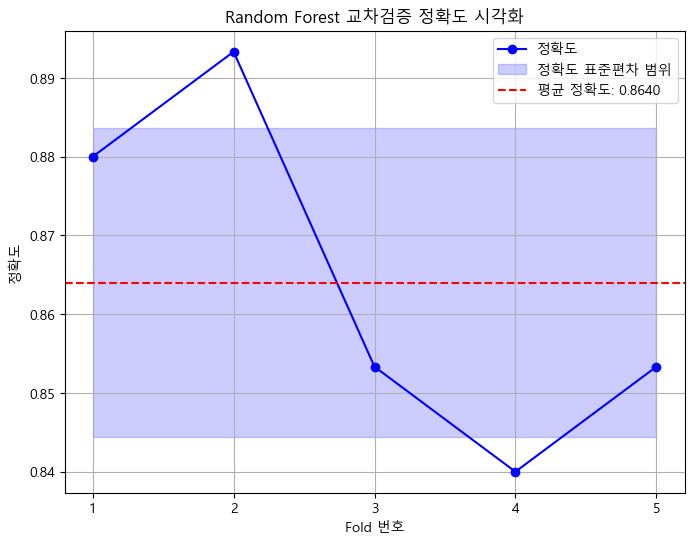

In [8]:
#교차검증 시각화
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import platform
import seaborn as sns
# 한글 폰트 설정
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
else:
    matplotlib.rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
# Fold 번호 배열 생성
folds = np.arange(1, len(cv_scores) + 1)
# 시각화
plt.figure(figsize=(8, 6))
plt.plot(folds, cv_scores, marker='o', linestyle='-', color='b', label='정확도')
plt.fill_between(folds,
                 np.mean(cv_scores) - np.std(cv_scores),
                 np.mean(cv_scores) + np.std(cv_scores),
                 color='b', alpha=0.2, label='정확도 표준편차 범위')
plt.axhline(np.mean(cv_scores), color='r', linestyle='--', label=f'평균 정확도: {np.mean(cv_scores):.4f}')
plt.title('Random Forest 교차검증 정확도 시각화')
plt.xlabel('Fold 번호')
plt.ylabel('정확도')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()


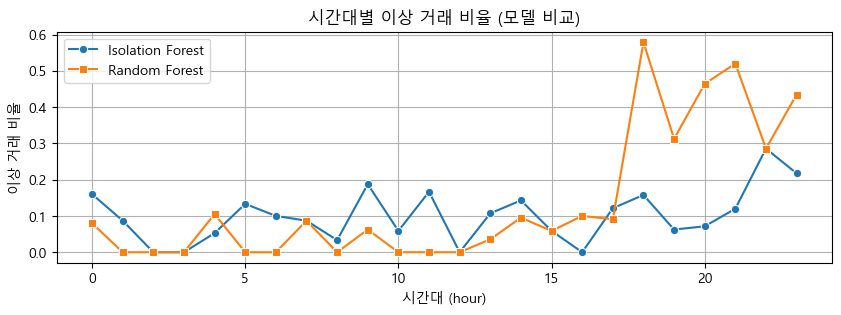

In [9]:
#시간대별 이상 거래 비율 비교 (IF vs RF)
# Isolation Forest 기준 시계열 비율 계산
hourly_iso = df.groupby(['hour', 'is_anomaly']).size().reset_index(name='count')
hourly_iso_pivot = hourly_iso.pivot(index='hour', columns='is_anomaly', values='count').fillna(0)
hourly_iso_pivot.columns = ['정상', '이상']
hourly_iso_pivot['isolation_비율'] = hourly_iso_pivot['이상'] / (hourly_iso_pivot['정상'] + hourly_iso_pivot['이상'])
# Random Forest 기준 시계열 비율 계산
hourly_rf = df.groupby(['hour', 'rf_pred']).size().reset_index(name='count')
hourly_rf_pivot = hourly_rf.pivot(index='hour', columns='rf_pred', values='count').fillna(0)
hourly_rf_pivot.columns = ['정상', '이상']
hourly_rf_pivot['rf_비율'] = hourly_rf_pivot['이상'] / (hourly_rf_pivot['정상'] + hourly_rf_pivot['이상'])
# 시각화
plt.figure(figsize=(10, 3))  # 기존 10x6 → 10x4로 높이만 축소
sns.lineplot(data=hourly_iso_pivot, x=hourly_iso_pivot.index, y='isolation_비율', marker='o', label='Isolation Forest')
sns.lineplot(data=hourly_rf_pivot, x=hourly_rf_pivot.index, y='rf_비율', marker='s', label='Random Forest')
plt.xlabel('시간대 (hour)')
plt.ylabel('이상 거래 비율')
plt.title('시간대별 이상 거래 비율 (모델 비교)')
plt.legend()
plt.grid(True)
plt.show()


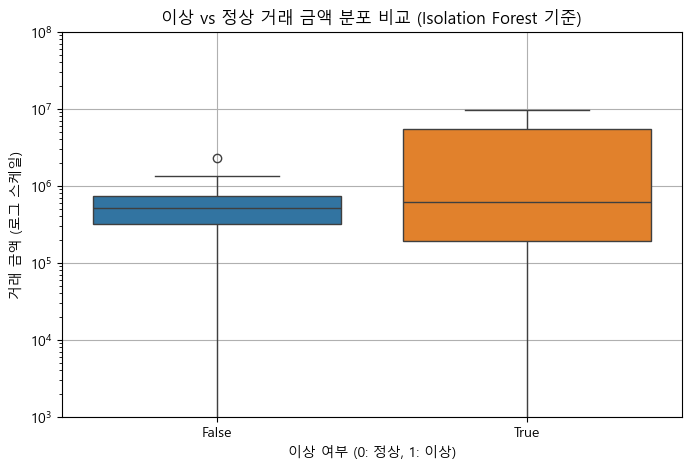

In [10]:
# 박스플롯을 통한 이상/정상 거래 금액 분포 시각화 (Isolation Forest 기준)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='is_anomaly', 
    y='amount', 
    hue='is_anomaly',       
    palette=['C0', 'C1'],
    legend=False
)
plt.yscale('log') 
plt.ylim(1e3, 1e8) 
plt.xlabel('이상 여부 (0: 정상, 1: 이상)')
plt.ylabel('거래 금액 (로그 스케일)')
plt.title('이상 vs 정상 거래 금액 분포 비교 (Isolation Forest 기준)')
plt.grid(True)
plt.show()

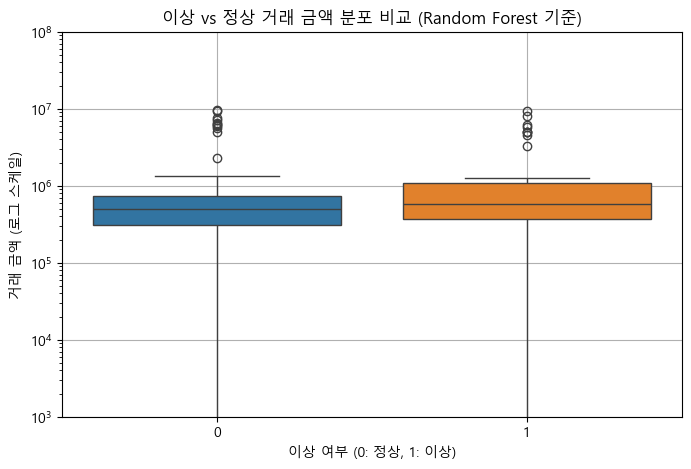

In [11]:
# 박스플롯을 통한 이상/정상 거래 금액 분포 시각화 (Random Forest 기준)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='rf_pred', 
    y='amount', 
    hue='rf_pred',       
    palette=['C0', 'C1'],
    legend=False
)
plt.yscale('log')  # 로그 스케일로 금액 차이 강조
plt.ylim(1e3, 1e8)  # 시각화 범위 설정
plt.xlabel('이상 여부 (0: 정상, 1: 이상)')
plt.ylabel('거래 금액 (로그 스케일)')
plt.title('이상 vs 정상 거래 금액 분포 비교 (Random Forest 기준)')
plt.grid(True)
plt.show()

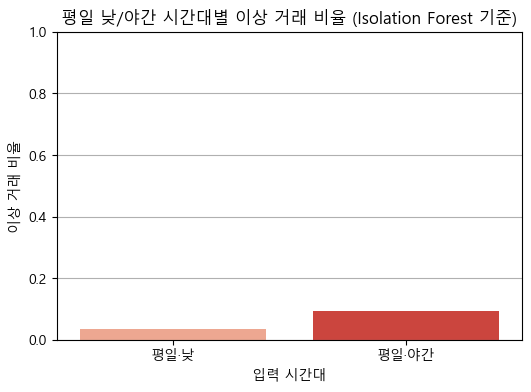

In [14]:
# 낮/야간 여부에 따른 이상 거래 비율 계산 (Isolation Forest 예측 기준)

# 1. 공휴일 제외한 평일 데이터 필터링
weekday_df = df[df['is_holiday'] == 0]
# 2. 낮/야간 여부에 따른 이상 거래 비율 계산
pivot = weekday_df.groupby('is_late_entry')['is_anomaly'].mean().reset_index()
# 3. 시각화를 위한 시간대 이름 추가
pivot['입력 시간대'] = pivot['is_late_entry'].map({
    0: '평일·낮',
    1: '평일·야간'
})
# 4. 막대그래프 시각화 (hue 지정 + 범례 비활성화)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=pivot,
    x='입력 시간대',
    y='is_anomaly',
    hue='입력 시간대',
    palette='Reds',
    legend=False
)
plt.title('평일 낮/야간 시간대별 이상 거래 비율 (Isolation Forest 기준)')
plt.ylabel('이상 거래 비율')
plt.xlabel('입력 시간대')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

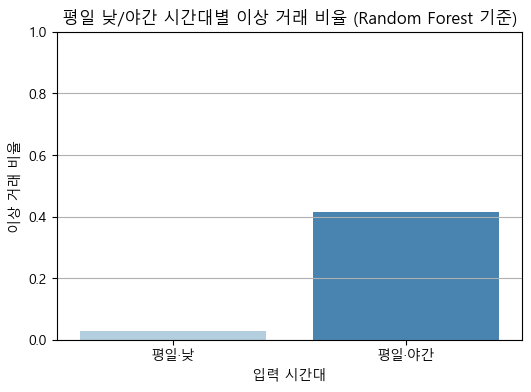

In [68]:
# 낮/야간 여부에 따른 이상 거래 비율 계산 (Random Forest 예측 기준)

# 공휴일 제외한 평일 데이터 필터링
weekday_df_rf = df[df['is_holiday'] == 0]
pivot_rf = weekday_df_rf.groupby('is_late_entry')['rf_pred'].mean().reset_index()
# 시각화를 위한 시간대 이름 매핑
pivot_rf['입력 시간대'] = pivot_rf['is_late_entry'].map({
    0: '평일·낮',
    1: '평일·야간'
})
# 막대그래프 시각화
plt.figure(figsize=(6, 4))
sns.barplot(
    data=pivot_rf,
    x='입력 시간대',
    y='rf_pred',
    hue='입력 시간대',
    palette='Blues',
    legend=False
)
plt.title('평일 낮/야간 시간대별 이상 거래 비율 (Random Forest 기준)')
plt.ylabel('이상 거래 비율')
plt.xlabel('입력 시간대')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

In [13]:
# 예측 결과 포함한 최종 결과 저장
import os
df.to_csv("fraud_detection_result.csv", index=False)
print(os.getcwd())


C:\Users\HyunSu\Downloads
